# Time-Dependent Schrodinger Equation Visualized

The Schrodinger equation is written as the following: 

$$ i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) \hspace{20mm} \psi(0, t) = \psi(L,t)=0 $$

You can kind of think of this as like conservation of energy for quantum-sized particles. The left hand term is the total energy and the two right hand terms are kinetic energy and potential energy of the particle, respectively.  

Some variables can be dropped from our equation from simplification such as: $m$, $\hbar$, and others. We can multiply both sides by $mL^2$ where $L$ is the characteristic length of the particle's journey.

$$ i mL^2 \hbar \frac{\partial}{\partial t} \psi = -\frac{1}{2}\hbar^2 L^2\frac{\partial^2}{\partial x^2}\psi + mL^2V(x) \psi $$

Taking $\hbar=1$ (So Joules=1/Seconds) we can change variables to make the equation look a little cleaner. Making the transformation: 

* $x'=\frac{x}{L}$
* $t' = \frac{t}{mL^2}$
* $V' = mL^2V$

These quantities are dimensionless so it is easy for us do our calcualtions now. We also don't have to worry about units when doing our calcualtions. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal


## Imports & Getting started

There are many imports that we must do in order to create plots, animations, and do the computations involving linear algebra. 

 - **import numpy** - this is needed to bring in the computation package numpy which allows us to do this type of math
 - **import matplotlib.pyplot** - we need this to generate the plots of the wavefunctions 
 - **import animation** - once we have generated our plots, I want to animate them so we can see how they change over time  
 - **import numba** - this is mainly for the execution level, it converts python code to machien code to improve speed
   - **import jit** - the part from **numba**, the main part that speeds up the code
 - **import eigh_tridiagonal** - solves the eigenvalue problem for a symmetric matrix (tridiagonal specification helps speed)

# Method #1 

The first way we can solve the above equation for $\psi(x,t)$ with the given boundary conditions is: 

Creating discrete points for the x-axis and discrete points for the y-axis so we can put these into the equation and get answer values. This method is kind of "hard-coding" our solution, but works well. 

We make a discrete grid with spacings of $\Delta x$ and $\Delta t$. Then, our $\psi_j^{m} $ becomes $ \psi(j\Delta x, m\Delta t)$. 

$$i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{1}{2}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +V(x)\psi_j^m$$

A simpler (and easier) way of writing this is, 

$$\psi_{j}^{m+1} = \psi_j^m + \frac{i}{2}\frac{\Delta t}{\Delta x^2}\left(\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}\right) - i \Delta tV(x)\psi_j^m$$

In [4]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

Here, we are creating variables to carry out our calculations. *Nx* represents the __ and *Nt* is the __ . We creating the x-axis using discrete values by using the numpy function *linspace*. The actual wavefunction, psi, was creating by using the one dimensional box with high potential setting. The potential, marked as V, is a function of *sigma* and *mu*, which are constants from nature.  


In [5]:
dt/dx**2

0.008999999999999998

This value of (dt/dx) is the derivative of space. We need it to be small in order to go through our calcualtions to know we are within boundaries. When it is small, that is when we can have good plots. 

Text(0, 0.5, '$V(x)$')

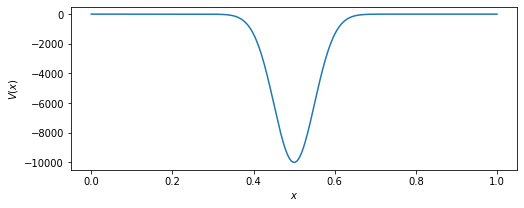

In [6]:
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

The diagram above shows us the ***Potential vs. X axis***. We can see how it is negative, and close to 0 farther away from x = 0.5. This is the potential we are modeling our particle to be in. It is significantly more differnet than the infinite potential wall, which essentially looks like a well.  

In [7]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [8]:
psi

array([[0.00000000e+00, 1.48093391e-02, 2.96170542e-02, ...,
        2.96170542e-02, 1.48093391e-02, 1.73191211e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [9]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

In [10]:
psi_m1 = compute_psi(psi.astype(complex))

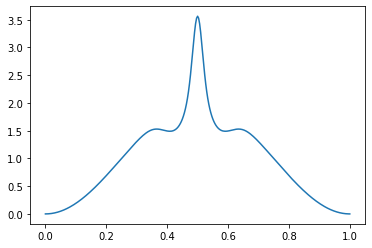

In [11]:
plt.plot(x, np.absolute(psi_m1[5000])**2)
#np.sum(np.absolute(psi_m1[10000])**2)*dx

# Method #2

This is the method we learn in school. It's the way you would find you would find someone solving the schrodinger equation on youtube or in a textbook. 

We first create a grid, but only for the x-axis values:

In [12]:
Nx = 301
dx = 1/(Nx-1)
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)

def V(x):
    mu, sigma = 1/2, 1/20
    return -1e4*np.exp(-(x-1/2)**2/(2*(1/20)**2))

Then, we create a matrix that would hold different values of the wavefunction. Then, it can also find the eigenstates using the *eigh_tridiagonal* function. 

In [13]:
d = 1/dx**2 + V(x)[1:-1]
e = -1/(2*dx**2) * np.ones(len(d)-1)
w, v = eigh_tridiagonal(d, e)

Lastly, we would need eigenstates and eigen-energies in order to get the final values of $\psi(x,t)$. Once we have $\psi(x,t)$ we can plot them and see what the wavefunction looks like. 

 Eigenstates would be $\psi_j$ and eigen-energies would be $E_j$: 
 
 $$\psi(x,t) = \sum_{j=0}^\infty c_j \psi_j(x) e^{-i E_j t} \hspace{20mm} c_j = \int_{-\infty}^{\infty} \psi(x, 0)\psi_j^*(x) dx$$ 

In [14]:
E_js = w[0:70]
psi_js = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode='constant')
cs = np.dot(psi_js, psi0)
def psi_m2(t):
    return psi_js.T@(cs*np.exp(-1j*E_js*t))

Now that we have our wavefunction, we can plot it *squared* in order to show us the probability function. 

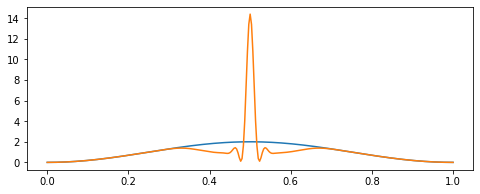

In [19]:
plt.figure(figsize=(8,3))
plt.plot(x, psi0**2)
plt.plot(x, np.absolute(psi_m2(10000*dt))**2)

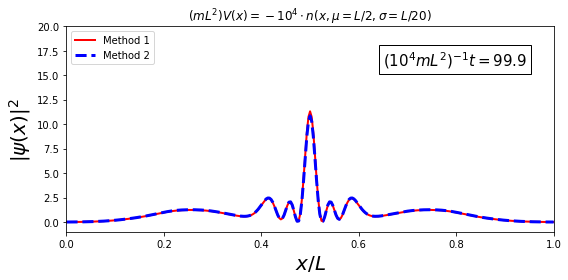

In [18]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    ln2.set_data(x, np.absolute(psi_m2(100*i*dt))**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('animatedWavefunction.gif',writer='pillow',fps=50,dpi=100)

# Changing Units (in reverse)

For all of this project, all the calculations were done in the dimensionless units, that is $\hbar$. Now, to get results that we would like, we have to convert our dimensionless units back to units with dimensions. 

## Potential 

We start with: $$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$$

Dividing by $\hbar^2$, for the left hand side, we get units that have proper units. Doing the math, we get: 

$$(mL^2/\hbar^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$$

$$\boxed{V(x) = \left(\frac{-10^4 \hbar^2}{mL^2}\right) n(x, \mu=L/2, \sigma=L/20)}$$

Here is the potential, now in the proper units format. 

## Time

Here, time is written as 

$$(10^4mL^2)^{-1}t= a$$

where $a$ is some dimensionless number. In order to make the LHS dimensionless (which currently has units of $J^{-1}s^{-1}$) we need to multiply by $\hbar$, leading to

$$\boxed{t= \left(\frac{10^4 mL^2}{\hbar}\right)a}$$

Here is the time, now in the proper units format. 

## $\psi$

Since $\psi$ depends on time, potential, and other natural constants only, if we fix those values, the wavefunction would be automatically fixed if we make the other changes. 